In [ ]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#ANN libreries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers

#clusters libraries
from sklearn.cluster import KMeans

## 1. Data

In [2]:
# read the data
base = pd.read_csv("data_pyme.csv")
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40117 entries, 0 to 40116
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   admission_date         40117 non-null  int64  
 1   income_monthly_amount  40117 non-null  float64
 2   balance_amount         40117 non-null  float64
 3   montoOR                40117 non-null  float64
 4   cantiOR                40117 non-null  float64
 5   transaOR               40117 non-null  float64
 6   montoDE                40117 non-null  float64
 7   cantiDE                40117 non-null  float64
 8   transaDE               40117 non-null  float64
 9   clasifica              40117 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 3.1 MB


In [3]:
base["clasifica"].value_counts()

1    36986
0     3131
Name: clasifica, dtype: int64

In [4]:
clasifica1 = base.query("clasifica == 1")
clasifica0 = base.query("clasifica == 0")

In [5]:
np.random.seed(42)
remove_n = len(clasifica1) - len(clasifica0)

drop_indices = np.random.choice(clasifica1.index, remove_n, replace=False)
data_1 = clasifica1.drop(drop_indices)

In [6]:
frames = [clasifica0,data_1]

In [7]:
data_concat = pd.concat(frames)

In [8]:
data_concat["clasifica"].value_counts()

1    3131
0    3131
Name: clasifica, dtype: int64

In [9]:
data_concat_sin_salida = data_concat.drop(['clasifica'], axis=1)

In [10]:
#normalizacion
mean = data_concat_sin_salida.mean()
std = data_concat_sin_salida.std()

data_norm_sin_salida = (data_concat_sin_salida - mean) / std

In [11]:
data = data_norm_sin_salida

In [12]:
data["salida"] = data_concat["clasifica"]

# 2. Cluster

In [15]:
# X: matriz de orden nxm, n: muestras, m:variables
# kMax: número máximo de clusters
def graficarInercia(X, kLista):
    
    inerciaList = []
    
    # hallar los diferentes clusters
    for k in kLista:
        kmeans = KMeans(n_clusters = k, 
                        random_state = 0, 
                        init = "random",
                        n_init = 10,
                        verbose = 0).fit(X)

        inerciaList.append(kmeans.inertia_)

    return kLista, inerciaList

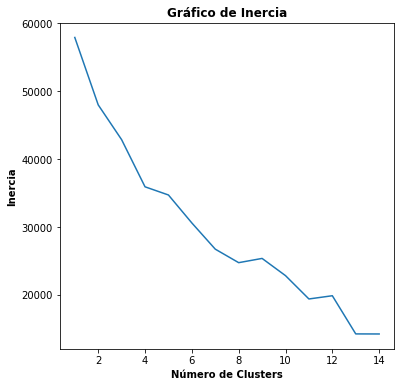

In [16]:
# gráfico de inercia para seleccionar el número adeuado de clusters
k_max = 15
x, y = graficarInercia(data, list(range(1, k_max)))

fig = plt.figure(figsize=(6,6))

plt.plot(x, y)
plt.title("Gráfico de Inercia", fontweight='bold')
plt.xlabel("Número de Clusters", fontweight='bold')
plt.ylabel("Inercia", fontweight='bold')
plt.xticks(list(range(2,k_max,2)))
plt.show()

In [17]:
# se escogió hallar 2 clusters
kmeans = KMeans(n_clusters = 2, 
                random_state = 42, 
                init = "random",
                n_init = 10,
                verbose = 0).fit(data)

### Capturar un registro al cluster

In [28]:
#captura registro
registro = [16,17218.00,3797.00,23568.00,11,8902,17879,6,3281]
registro_numpy = np.array(registro).reshape(1, -1)
salCluster = 1

#norma
mean_reg = registro_numpy.mean()
std_reg = registro_numpy.std()
registro_numpy_norma = (registro_numpy - mean_reg) / std_reg
registro_numpy_norma = np.append(registro_numpy_norma,salCluster).reshape(1, -1)

#insertar al cluster
clustersWEB = kmeans.predict(registro_numpy_norma)

In [29]:
#NOMBRE DEL CLUSTER! --> cluster 0
clustersWEB

array([0], dtype=int32)

In [22]:
# almacenar los clusteres hallados
k_means_clusters = kmeans.predict(data)

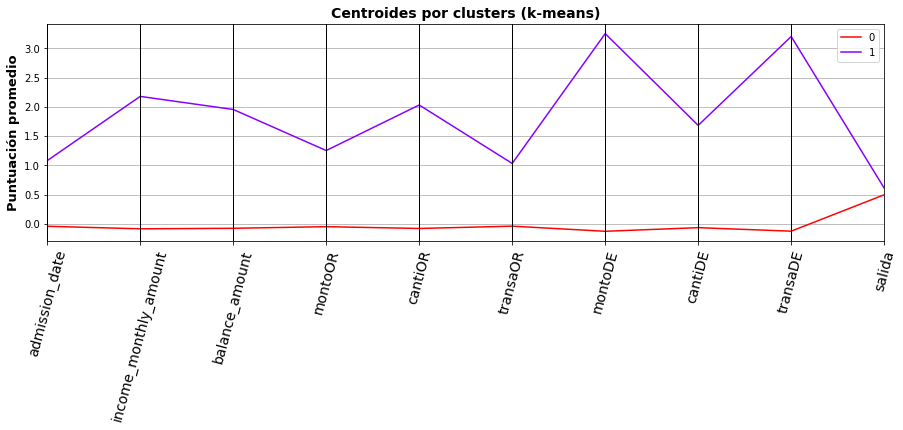

In [23]:
#graficar clusters

temp_df = pd.DataFrame(kmeans.cluster_centers_, columns=data.columns)
temp_df["k_means"] = kmeans.predict(temp_df.values)  # rename clusters names


fig = plt.figure(figsize=(15,4))

chart = pd.plotting.parallel_coordinates(
   frame = temp_df,
   class_column = "k_means",
   color = ('#fe0400', '#8800FF', '#1bb02a', '#ff00ff'))

chart.set_title("Centroides por clusters (k-means)", fontsize=14, fontweight='bold')
chart.set_ylabel("Puntuación promedio",fontsize=13, fontweight='bold')
chart.set_xticklabels(chart.get_xticklabels(), rotation=75, fontsize=14);

In [24]:
import collections, numpy

#cantidad de datos en cada cluster
collections.Counter(k_means_clusters)

Counter({0: 6024, 1: 238})

- Cluster 0: todo bajo (mas empresas)
- cluster 1: Todo alto (menos empresas)


# Redes Neuronales

## 1. Data

In [ ]:
#convirtiendo a numpy data
data_numpy = data.values

In [ ]:
clusterID = k_means_clusters

data_numpy_cluster = data_numpy

data_numpy_cluster = np.insert(data_numpy_cluster, len(data_numpy_cluster[0]+1), clusterID, axis=1)

In [ ]:
def extraigoCluster(a):
    
    cluster0 = []

    #recorro todo el data set
    for i in range(len(data_numpy_cluster)):
    
        #condicion para solo tomar labels 0 o 1
        if(data_numpy_cluster[i,-1] == a):
            cluster0.append(data_numpy_cluster[i])

    return np.array(cluster0)

In [ ]:
#agregando columnda de label de cluster y separando cada cluster en una variables
cluster0_np = extraigoCluster(0)
cluster1_np = extraigoCluster(1)

In [ ]:
cluster0_np_total = np.delete(cluster0_np, -1, axis=1)
cluster1_np_total = np.delete(cluster1_np, -1, axis=1)

In [ ]:
cluster0_np_total[0]

# 3. Redes Neuronales

### 3.1. Cluster 0

In [ ]:
#Preparing inputs y outputs

ind_variables = len(cluster0_np_total[0])

In [ ]:
#data y labels

X = cluster0_np_total[:, :ind_variables]
Y = cluster0_np_total[:, -1]

In [ ]:
#train-test split  80% train / 20%testear

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## 2. Arquitectura

In [ ]:
X[0]

In [ ]:
#infraestructuta de red

model_1 = Sequential([
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='relu'),
])


# configuracion de red

model_1.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = 'mae',
    metrics = ['accuracy'])

In [ ]:
Y[0]

In [ ]:
history = model_1.fit(x = X_train, 
                    y = y_train, 
                    validation_data = (X_test, y_test),
                    epochs=50
                    )

In [ ]:
# metrics
print("final metrics:", model_1.evaluate(X_test, y_test, verbose=False))


In [ ]:
X_test.shape

In [ ]:
registro_numpy_norma.shape

In [ ]:
Xnew = registro_numpy_norma
ynew = model_1.predict_classes(Xnew)

### 3.2 Cluster 1

In [ ]:
#Preparing inputs y outputs

ind_variables1 = len(cluster1_np_total[0])-2

In [ ]:
#data y labels

X1 = cluster1_np_total[:, :ind_variables1]
Y1 = cluster1_np_total[:, -1]

In [ ]:
#train-test split  80% train / 20%testear

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)

In [ ]:
#infraestructuta de red

model_2 = Sequential([
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='relu'),
])


# configuracion de red

model_2.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = 'mae',
    metrics = ['accuracy'])

In [ ]:
history = model_2.fit(x = X1_train, 
                    y = y1_train, 
                    validation_data = (X1_test, y1_test),
                    epochs=50
                    )

In [ ]:
# metrics
print("final metrics:", model_2.evaluate(X1_test, y1_test, verbose=False))

In [ ]:
X1_test[0]

In [ ]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)